<p align="center">
<img align="center" src="https://image.freepik.com/free-vector/surprised-talking-robot-speech-bubbles-chatbot-dialog-online-lesson_74855-103.jpg">
</p>

[Image source](https://www.freepik.com/free-vector/surprised-talking-robot-speech-bubbles-chatbot-dialog-online-lesson_3734224.htm)


<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">Dialog-based <br> chatbot.</h1>

## Please use nbviewer to read this notebook to use all it's features:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/NaturalLanguage/DialogBasedChatbot/DialogBasedChatbot.ipynb

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>

## 1. [Load data.](#Step1)
## 2. [Preprocessing and normalization.](#Step2)
## 3. [Prepare data for Tensorflow.](#Step3)
## 4. [Create encoder-decoder models.](#Step4)
## 5. [Check the work of a model.](#Step5)
## 6. [Conclusion.](#Step6)


## Dialog-based chatbot.
## Goal: create a chatbot based on dialog history.

This notebook was created in Google Collab.

Dataset source:
https://www.kaggle.com/grafstor/simple-dialogs-for-chatbot

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

pd.options.display.max_colwidth = 150

<div id="Step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. Load data</span>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWhY-DGycZ4qQzeZK90fKycOKVvmRa5GMUYRqZ5fZxhu-Egt3aQmpJI
Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Encoder decoder/Data/dialogs.txt', 
                 sep='\t', names=['Question', 'Answer'])
df[:3]

Question                               Answer
0               hi, how are you doing?        i'm fine. how about yourself?
1        i'm fine. how about yourself?  i'm pretty good. thanks for asking.
2  i'm pretty good. thanks for asking.    no problem. so how have you been?

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3725 entries, 0 to 3724
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  3725 non-null   object
 1   Answer    3725 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB


In [6]:
df.isna().sum()

Question    0
Answer      0
dtype: int64

<div id="Step2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 2. Preprocessing and normalization.</span>

## Text preprocessing:
1. Remove doubles.
2. Replace contractions.
3. Replace numbers and ordinals.
4. Remove punctuation.

## Remove doubles

In [7]:
df.drop_duplicates(subset='Question', inplace=True)

## Replace contractions

In [9]:
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['QuestionDecontracted'] = df['Question'].apply(decontracted)
df['AnswerDecontracted'] = df['Answer'].apply(decontracted)
df[:3]

Question  ...                    AnswerDecontracted
0               hi, how are you doing?  ...        i am fine. how about yourself?
1        i'm fine. how about yourself?  ...  i am pretty good. thanks for asking.
2  i'm pretty good. thanks for asking.  ...     no problem. so how have you been?

[3 rows x 4 columns]

## Remove text numbers and ordinal text numbers

In [12]:
def numbers_regex(length, ordinal=False):
    from num2words import num2words
    numbers_list = \
        [num2words(number, ordinal=ordinal) for number in range(length)]
    numbers_regex = \
        '|'.join([f'^{number_text}\s|\s{number_text}\s|\s' \
                     f'{number_text}$' for number_text in numbers_list])
    return numbers_regex

In [15]:
placeholder = ' NumberText '
df['QuestionNoNumbers'] = \
    df['QuestionDecontracted'].str.replace(numbers_regex(100, ordinal=False),
                                           placeholder, regex=True)
df['AnswerNoNumbers'] = \
    df['AnswerDecontracted'].str.replace(numbers_regex(100, ordinal=False),
                                           placeholder, regex=True)
placeholder = ' OrdinalText '
df['QuestionNoNumbers'] = \
    df['QuestionNoNumbers'].str.replace(numbers_regex(100, ordinal=True),
                                           placeholder, regex=True)
df['AnswerNoNumbers'] = \
    df['AnswerNoNumbers'].str.replace(numbers_regex(100, ordinal=True),
                                           placeholder, regex=True)
df[:3]

Question  ...                       AnswerNoNumbers
0               hi, how are you doing?  ...        i am fine. how about yourself?
1        i'm fine. how about yourself?  ...  i am pretty good. thanks for asking.
2  i'm pretty good. thanks for asking.  ...     no problem. so how have you been?

[3 rows x 6 columns]

## Remove numbers

In [17]:
placeholder = ' NumberDigits '
df['QuestionNoNumbers'] = \
    df['QuestionNoNumbers'].str.replace('^\d+\s|\s\d+\s|\s\d+$', placeholder,
                                      regex=True)
df['AnswerNoNumbers'] = \
    df['AnswerNoNumbers'].str.replace('^\d+\s|\s\d+\s|\s\d+$', placeholder,
                                      regex=True)
df[:3]

Question  ...                       AnswerNoNumbers
0               hi, how are you doing?  ...        i am fine. how about yourself?
1        i'm fine. how about yourself?  ...  i am pretty good. thanks for asking.
2  i'm pretty good. thanks for asking.  ...     no problem. so how have you been?

[3 rows x 6 columns]

## Remove punctuation

In [18]:
import string
df['QuestionNoPunctuation'] = df['QuestionNoNumbers']
df['AnswerNoPunctuation'] = df['AnswerNoNumbers']
for c in string.punctuation + '\n' + '\r':
    df['QuestionNoPunctuation'] = \
        df['QuestionNoPunctuation'].str.replace(c, " ", regex=False)
    df['AnswerNoPunctuation'] = \
        df['AnswerNoPunctuation'].str.replace(c, " ", regex=False)
df[:3]

Question  ...                   AnswerNoPunctuation
0               hi, how are you doing?  ...        i am fine  how about yourself 
1        i'm fine. how about yourself?  ...  i am pretty good  thanks for asking 
2  i'm pretty good. thanks for asking.  ...     no problem  so how have you been 

[3 rows x 8 columns]

<div id="Step3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 3. Prepare data for Tensorflow.</span>

## Add 'StartPlaceholder' in the beginning and 'EndPlaceholder' in the end.

In [19]:

df['PreprocessedQuestion'] = 'StartPlaceholder ' + df['QuestionNoPunctuation']\
                             + ' EndPlaceholder'
df['PreprocessedAnswer'] = 'StartPlaceholder ' + df['AnswerNoPunctuation'] +\
                           ' EndPlaceholder'
df[:3]

Question  ...                                                    PreprocessedAnswer
0               hi, how are you doing?  ...        StartPlaceholder i am fine  how about yourself  EndPlaceholder
1        i'm fine. how about yourself?  ...  StartPlaceholder i am pretty good  thanks for asking  EndPlaceholder
2  i'm pretty good. thanks for asking.  ...     StartPlaceholder no problem  so how have you been  EndPlaceholder

[3 rows x 10 columns]

## Prepare data for Tensorflow:
1. Tokenize
2. Pad
3. One-hot encode

## Tokenize

In [21]:
texts = df['PreprocessedQuestion']
texts = texts.append(df['PreprocessedAnswer'])

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
df['QuestionTokenized'] = \
    tokenizer.texts_to_sequences(df['PreprocessedQuestion'])
df['AnswerTokenized'] = \
    tokenizer.texts_to_sequences(df['PreprocessedAnswer'])
df[:3]

Question  ...                       AnswerTokenized
0               hi, how are you doing?  ...       [1, 3, 28, 570, 39, 36, 512, 2]
1        i'm fine. how about yourself?  ...  [1, 3, 28, 145, 45, 225, 29, 477, 2]
2  i'm pretty good. thanks for asking.  ...    [1, 32, 161, 24, 39, 14, 4, 90, 2]

[3 rows x 12 columns]

In [24]:
total_words = len(tokenizer.word_index) + 1
print(f'Total number of different words: {total_words}')

Total number of different words: 2436


## Pad Sequences

In [25]:
max_question_length = max([len(answer) for answer in df['QuestionTokenized']])
max_answer_length = max([len(answer) for answer in df['AnswerTokenized']])
print(f'Max question length: {max_question_length}, '
      f'max answer length: {max_answer_length}')
max_seq_length =  max(max_question_length, max_answer_length)

Max question length: 22, max answer length: 22


In [30]:
question_seq = pad_sequences(df['QuestionTokenized'], maxlen=max_seq_length,
                             padding='post')
answer_seq = pad_sequences(df['AnswerTokenized'], maxlen=max_seq_length,
                           padding='post')
print(f'Shapes of question and answer: {question_seq.shape}, '
      f'{answer_seq.shape}')

Shapes of question and answer: (3510, 22), (3510, 22)


In [31]:
enc_input = to_categorical(question_seq, num_classes=total_words)
dec_input = to_categorical(answer_seq, num_classes=total_words)
print(f'One-hot encoded shapes: {enc_input.shape}, {dec_input.shape}')

One-hot encoded shapes: (3510, 22, 2436), (3510, 22, 2436)


## Create target sequence

In [34]:
dec_target = np.roll(dec_input, -1, axis=1)
dec_target[:, -1, :] = 0
print(f'Shape of target sequence: {dec_target.shape}')

Shape of target sequence: (3510, 22, 2436)


## Function to transform from one-hot encoded numberical form into word form.

In [35]:
def decode_seq(seq):
    words_list = \
        tokenizer.sequences_to_texts(np.argmax(seq, axis=-1).reshape(-1, 1))
    result = ' '.join(words_list).strip()
    return result

In [36]:
print(f'enc_input:  {decode_seq(enc_input[1])}\n'
      f'dec_input:  {decode_seq(dec_input[1])}\n'
      f'dec_target: {decode_seq(dec_target[1])}')

enc_input:  startplaceholder i am fine how about yourself endplaceholder
dec_input:  startplaceholder i am pretty good thanks for asking endplaceholder
dec_target: i am pretty good thanks for asking endplaceholder


<div id="Step4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 4. Create encoder-decoder models.</span>

## Models
1. Train model
2. Encoder model
3. Decoder model

## Train model

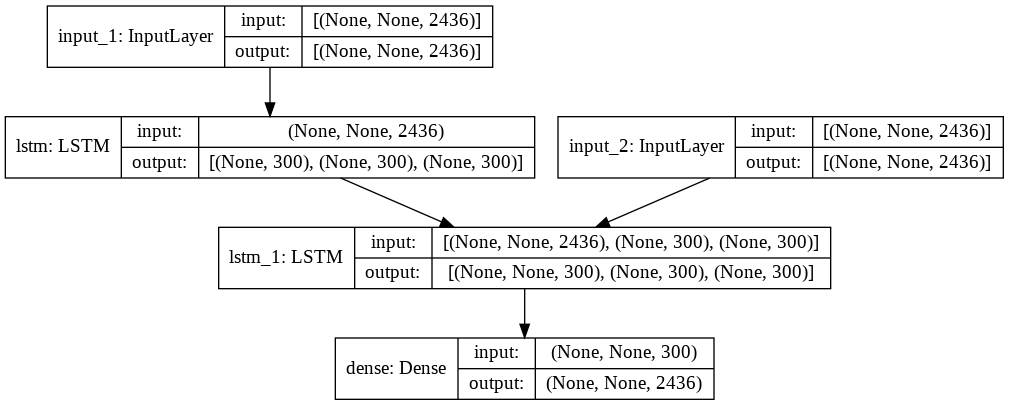

In [37]:
lstm_units = 300
encoder_input = Input(shape=(None, total_words))
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_input)
encoder_states = [encoder_state_h, encoder_state_c]
decoder_input = Input(shape=(None, total_words))
decoder_lstm = LSTM(lstm_units, return_state=True, return_sequences=True)
decoder_output, decoder_state_h, decoder_state_c = decoder_lstm\
    (decoder_input, initial_state=encoder_states)
# decoder_states = [decoder_state_h, decoder_state_c]
decoder_dense = Dense(total_words, activation='softmax')
decoder_output = decoder_dense(decoder_output)
train_model = Model([encoder_input, decoder_input], decoder_output)
plot_model(train_model, show_shapes=True)

## Encoder model

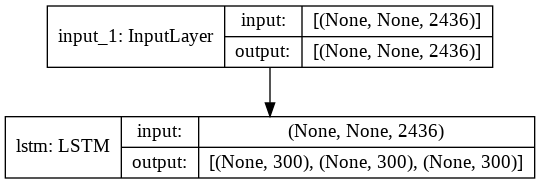

In [38]:
encoder_model = Model(encoder_input, encoder_states)
plot_model(encoder_model, show_shapes=True)

## Decoder model

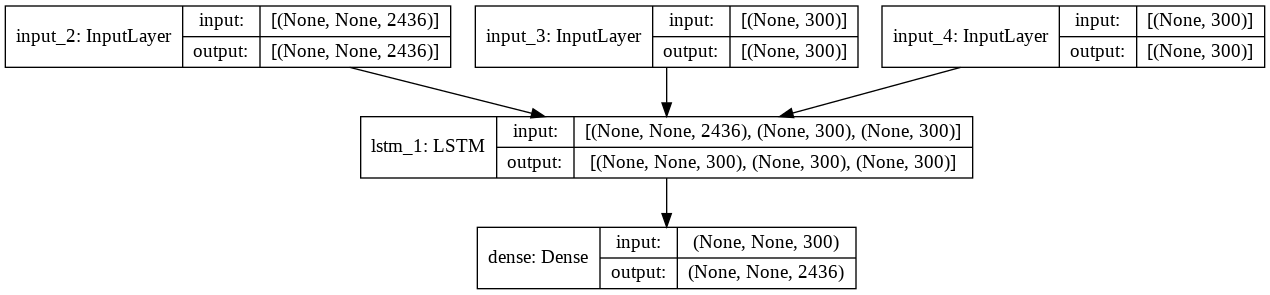

In [39]:
decoder_input_h = Input(shape=(lstm_units, ))
decoder_input_c = Input(shape=(lstm_units, ))
decoder_input_states = [decoder_input_h, decoder_input_c]
decoder_output, state_h, state_c = decoder_lstm\
    (decoder_input, initial_state=decoder_input_states)
decoder_states = [state_h, state_c]
decoder_output = decoder_dense(decoder_output)
decoder_model = Model([decoder_input] + decoder_input_states,
                      [decoder_output] + decoder_states)
plot_model(decoder_model, show_shapes=True)

In [40]:
train_model.compile(optimizer='adam', loss='categorical_crossentropy',
                    metrics='accuracy')
train_model.fit([enc_input, dec_input], dec_target, epochs=100)

Epoch 1/100
110/110 [==============================] - 13s 45ms/step - loss: 2.6643 - accuracy: 0.6458
Epoch 2/100
110/110 [==============================] - 5s 45ms/step - loss: 2.1678 - accuracy: 0.6567
Epoch 3/100
110/110 [==============================] - 5s 43ms/step - loss: 2.1059 - accuracy: 0.6631
Epoch 4/100
110/110 [==============================] - 5s 44ms/step - loss: 2.0067 - accuracy: 0.6768
Epoch 5/100
110/110 [==============================] - 5s 44ms/step - loss: 1.8971 - accuracy: 0.6967
Epoch 6/100
110/110 [==============================] - 5s 45ms/step - loss: 1.8296 - accuracy: 0.7064
Epoch 7/100
110/110 [==============================] - 5s 44ms/step - loss: 1.7721 - accuracy: 0.7110
Epoch 8/100
110/110 [==============================] - 5s 44ms/step - loss: 1.7216 - accuracy: 0.7147
Epoch 9/100
110/110 [==============================] - 5s 44ms/step - loss: 1.6747 - accuracy: 0.7179
Epoch 10/100
110/110 [==============================] - 5s 44ms/step - loss: 1.63

<div id="Step5">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 5. Check the work of a model.</span>


In [41]:
print(f'enc_input:  {decode_seq(enc_input[1])}\n'
      f'dec_input:  {decode_seq(dec_input[1])}\n'
      f'dec_target: {decode_seq(dec_target[1])}')

enc_input:  startplaceholder i am fine how about yourself endplaceholder
dec_input:  startplaceholder i am pretty good thanks for asking endplaceholder
dec_target: i am pretty good thanks for asking endplaceholder


In [43]:
test_sample = enc_input[1].reshape(1, max_seq_length, total_words)
decode_seq(test_sample)

'startplaceholder i am fine how about yourself endplaceholder'

In [44]:
def predict(test_sample):
    encoder_state_h, encoder_state_c = encoder_model.predict(test_sample)
    h_prev = \
        np.array([0 for i in range(total_words)]).reshape(1, 1, total_words)
    pred = []
    for i in range(max_seq_length):
        pred_output, encoder_state_h, encoder_state_c = \
            decoder_model.predict([h_prev, encoder_state_h, encoder_state_c])
        decoded_output = decode_seq(pred_output[0][0])
        if decoded_output == 'endplaceholder':
            break

        pred.append(decoded_output)
        h_prev = pred_output
    return pred
predict(test_sample)

['i', 'am', 'pretty', 'good', 'thanks', 'for', 'asking']

<div id="Step6">
</div>

# <span style="color:#01872A; display: block; padding:10px;background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;"> Step 6. Save the models and the tokenizer for future use.</span>

In [45]:
dest_folder = '/content/drive/MyDrive/Colab Notebooks/Encoder decoder/Data/'
encoder_model.save(dest_folder + 'enc_model_collab.h5')
decoder_model.save(dest_folder + 'enc_model_collab.h5')

import pickle
output = open(dest_folder + 'tokenizer.pkl', 'wb')
pickle.dump(tokenizer, output)
output.close()

<div id="Step7">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 6. Conclusion.</span>

1. Sequence-to-sequence prediction system was created.
2. Used encoder-decoder architecture.
3. For practical use check file: 'chatbot.py', here is a gif with demo of the
 work.

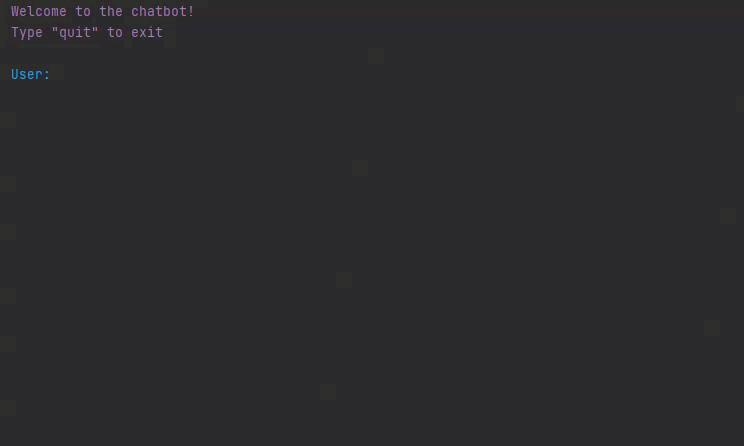

In [5]:
Image(open('Data/Chatbot.gif','rb').read(), height=700, width=700)